#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install  catboost


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import warnings



from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

STATE = 17
figsize = (18,8)
warnings.filterwarnings("ignore")
url = 'https://code.s3.yandex.net/datasets/taxi.csv'

In [3]:
# загружаем данные, устанавливаем индекс таблицы равным столбцу datetime
# сортируем индексы
# выводим информацию о датафрейме

data = pd.read_csv(url, index_col=[0], parse_dates=['datetime'])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# проверим в хронологическом ли порядке расположены даты

print(data.index.is_monotonic)

True


## Анализ

<AxesSubplot:xlabel='datetime'>

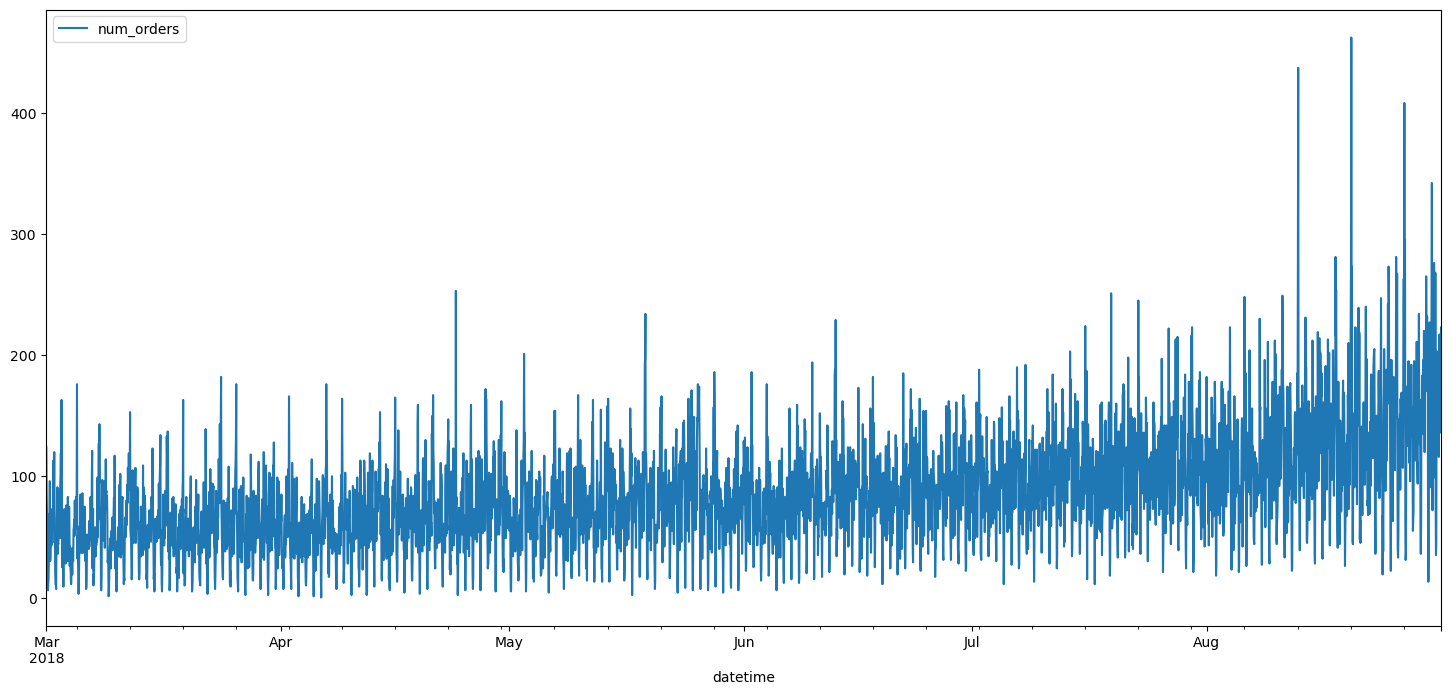

In [5]:
# ресемплируем данные по 1 часу, строим график временного ряда

data = data.resample('1H').sum()
data.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

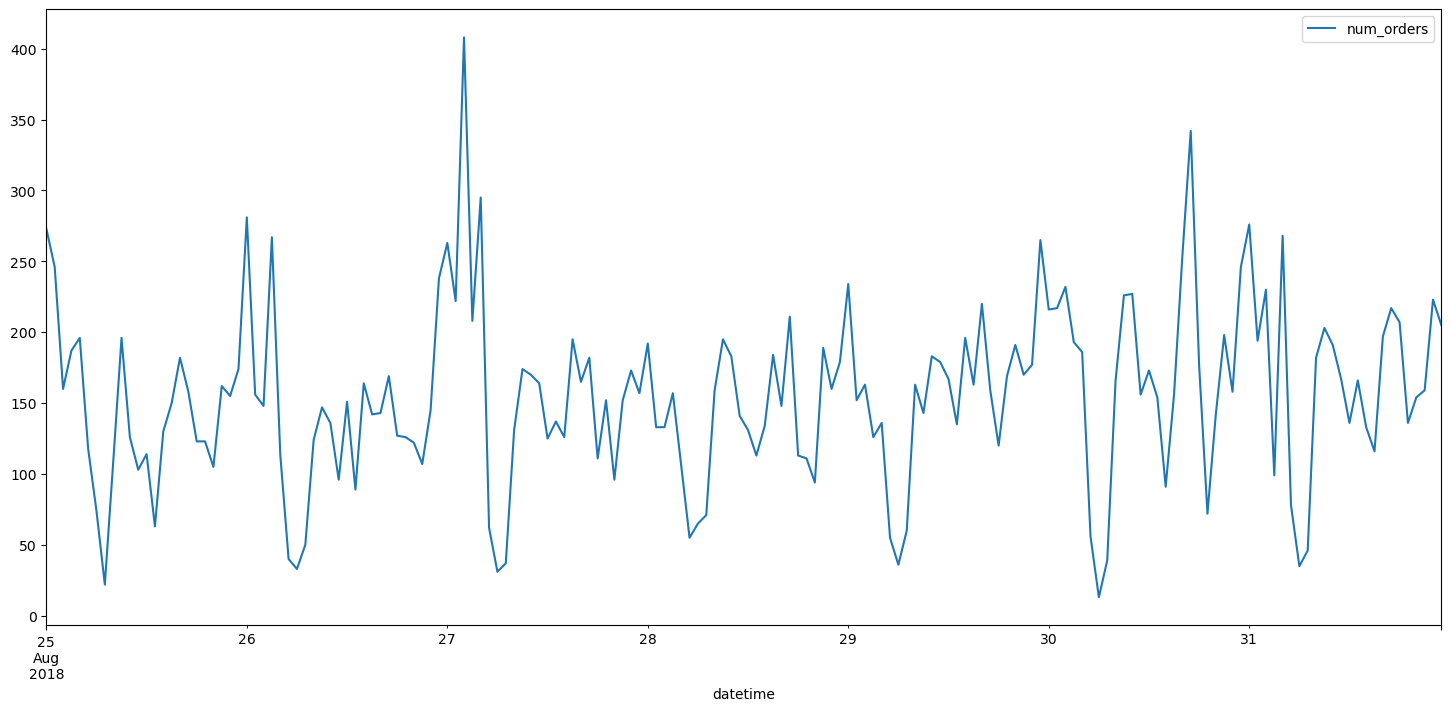

In [6]:
# строим график временного ряда за последнюю неделю

data['2018-08-25':].plot(figsize=figsize)

<AxesSubplot:title={'center':'All period'}, xlabel='datetime'>

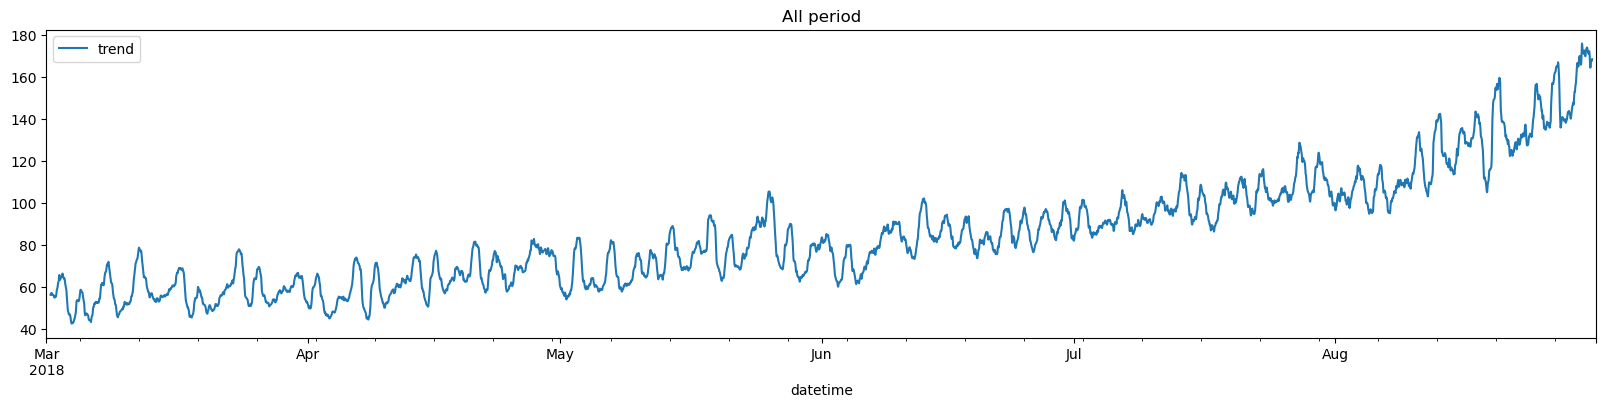

In [7]:
# рассмотрим тренды и сезонность
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=(20,4), legend=True, title='All period')

<AxesSubplot:title={'center':'All period'}, xlabel='datetime'>

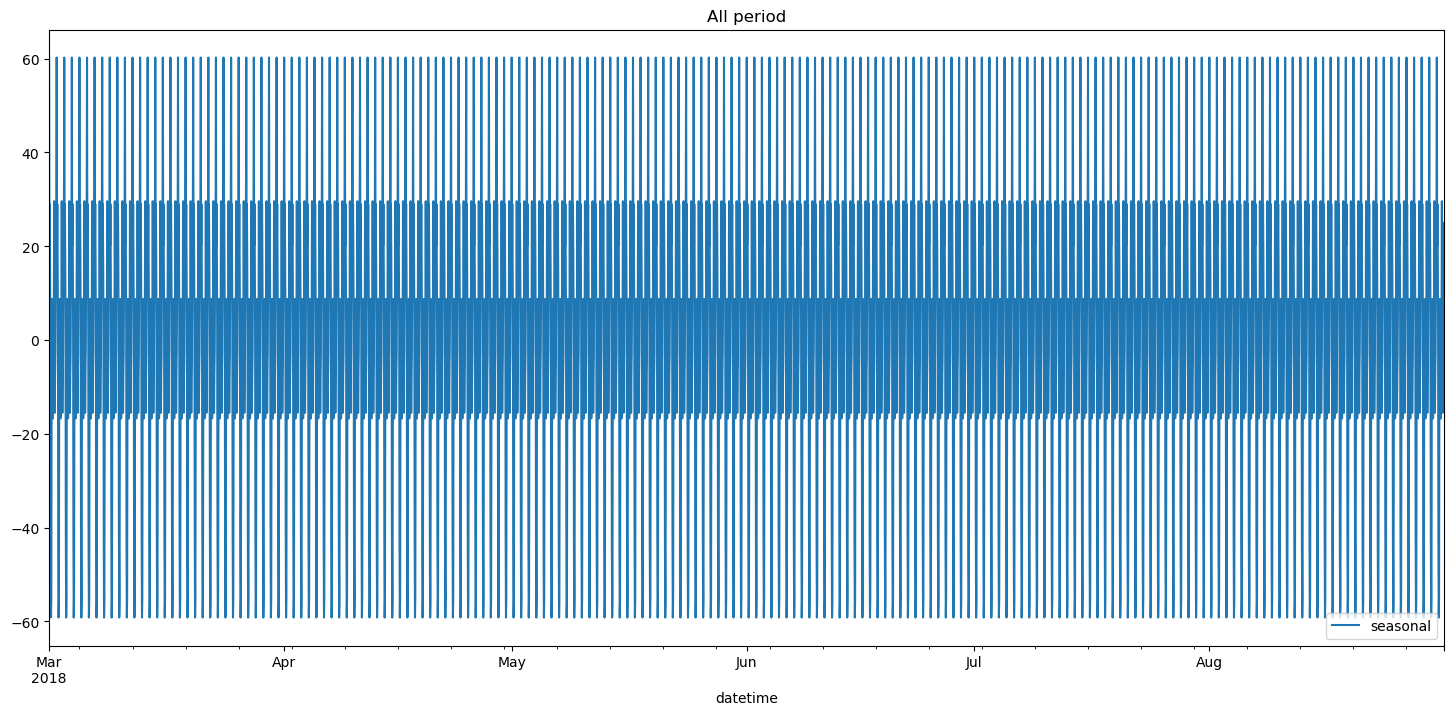

In [8]:
decomposed_data.seasonal.plot(figsize=figsize, legend=True, title='All period')

<AxesSubplot:title={'center':'All period'}, xlabel='datetime'>

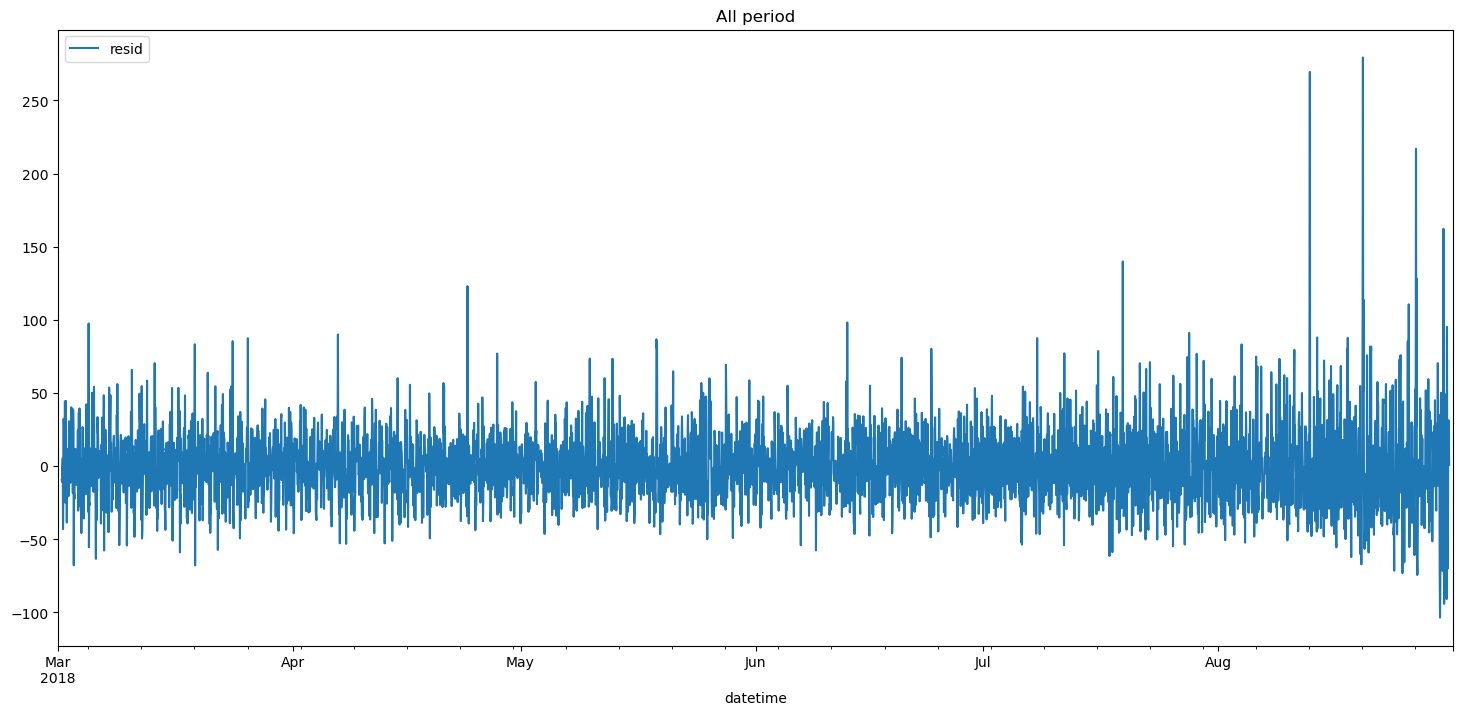

In [9]:
decomposed_data.resid.plot(figsize=figsize, legend=True, title='All period')

<AxesSubplot:title={'center':'Last week'}, xlabel='datetime'>

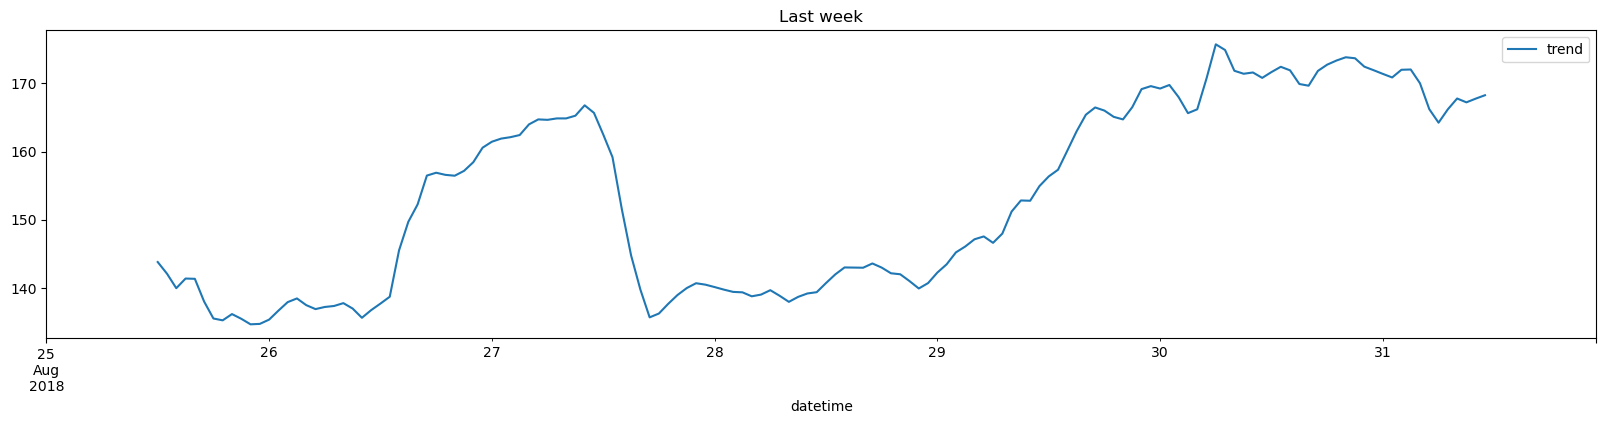

In [10]:
decomposed_data = seasonal_decompose(data['2018-08-25':])
decomposed_data.trend.plot(figsize=(20,4), legend=True, title='Last week')

<AxesSubplot:title={'center':'Last week'}, xlabel='datetime'>

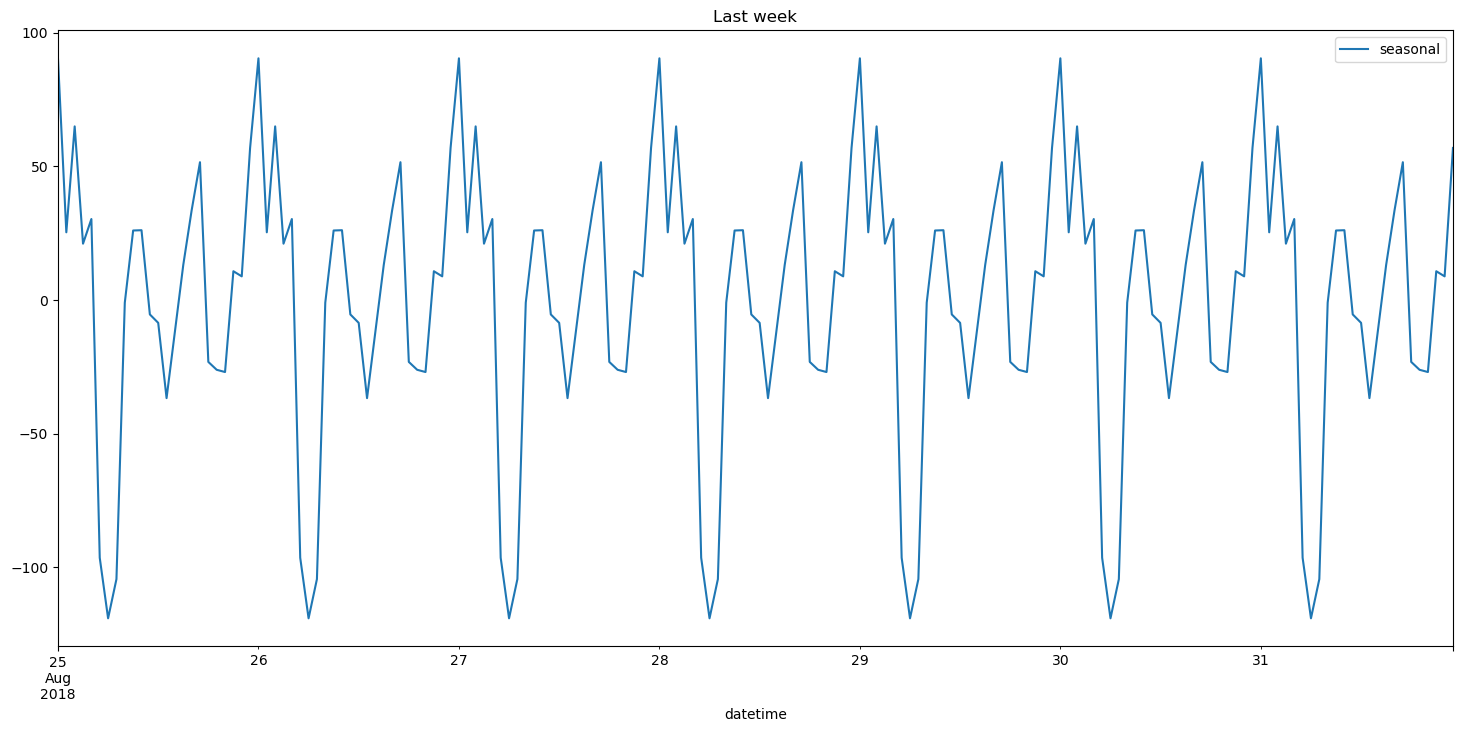

In [11]:
decomposed_data.seasonal.plot(figsize=figsize, legend=True, title='Last week')

<AxesSubplot:title={'center':'Last week'}, xlabel='datetime'>

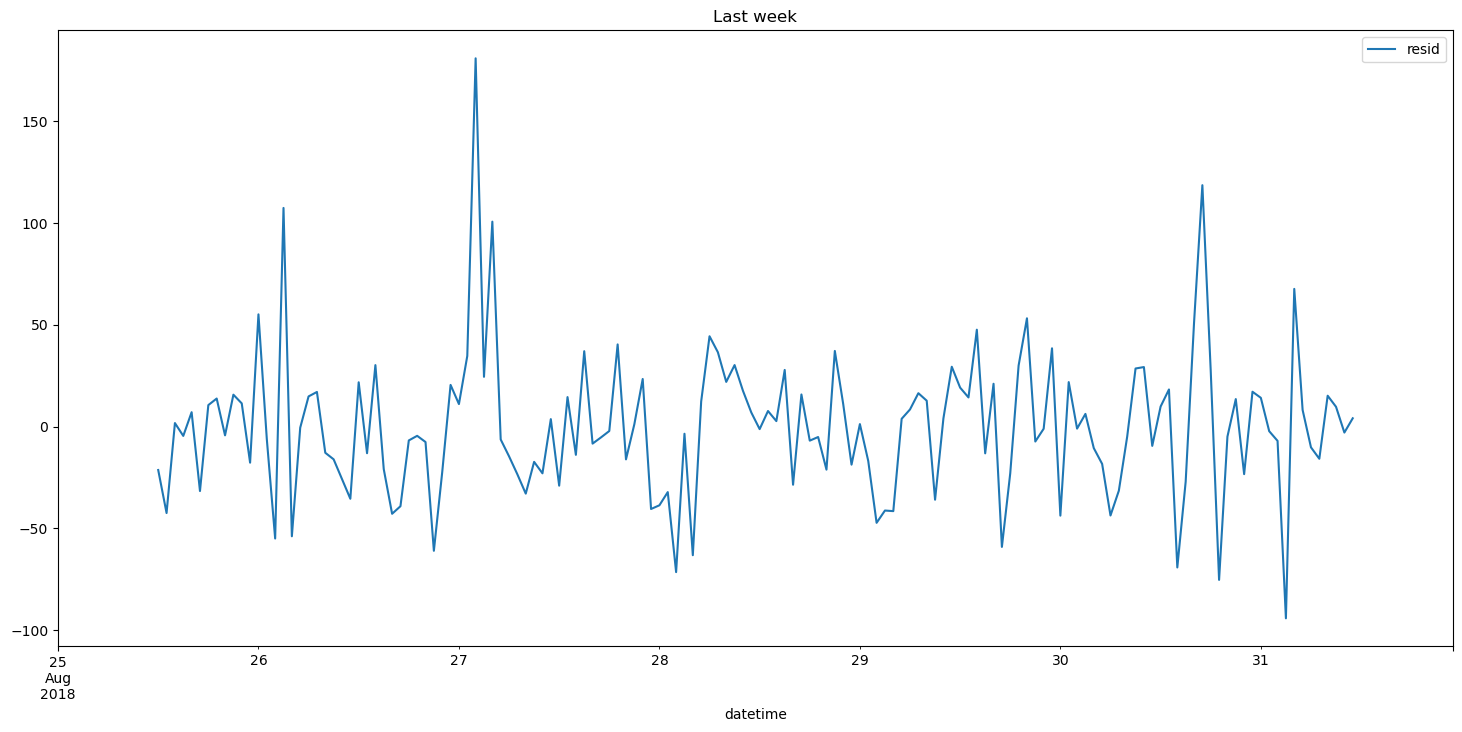

In [12]:
decomposed_data.resid.plot(figsize=figsize, legend=True, title='Last week')

<AxesSubplot:title={'center':'Last 3 months'}, xlabel='datetime'>

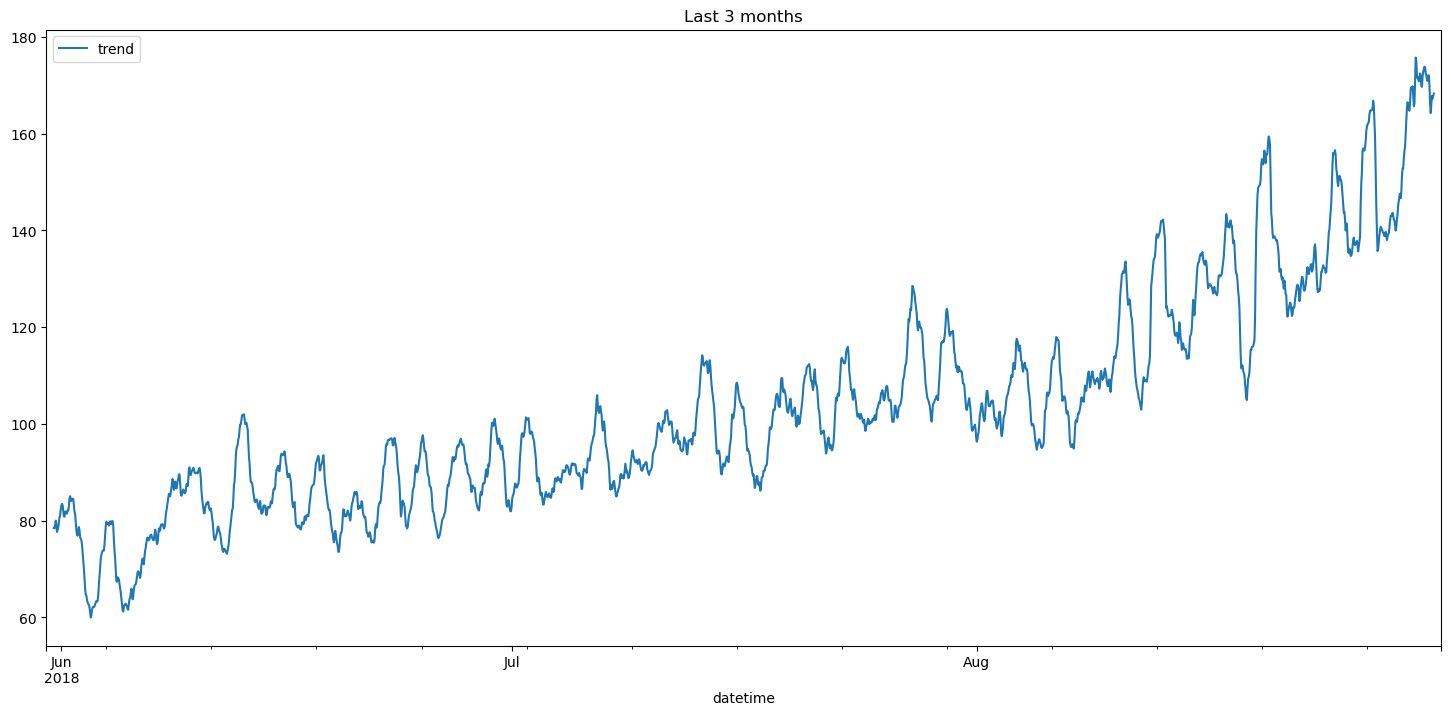

In [13]:
decomposed_data = seasonal_decompose(data['2018-05-31':'2018-08-31'])
decomposed_data.trend.plot(figsize=figsize, legend=True, title='Last 3 months')

<AxesSubplot:title={'center':'Last 3 months'}, xlabel='datetime'>

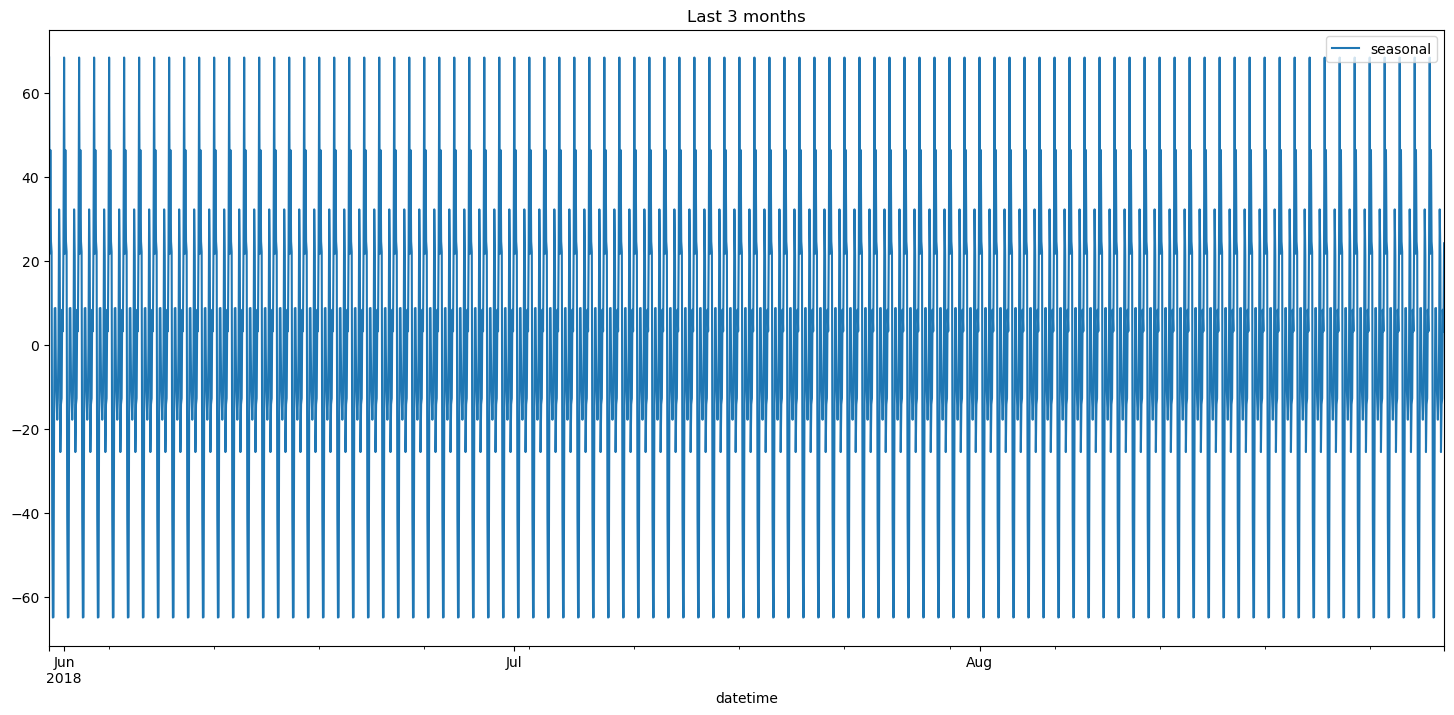

In [14]:
decomposed_data.seasonal.plot(figsize=figsize, legend=True, title='Last 3 months')

<AxesSubplot:title={'center':'Last 3 months'}, xlabel='datetime'>

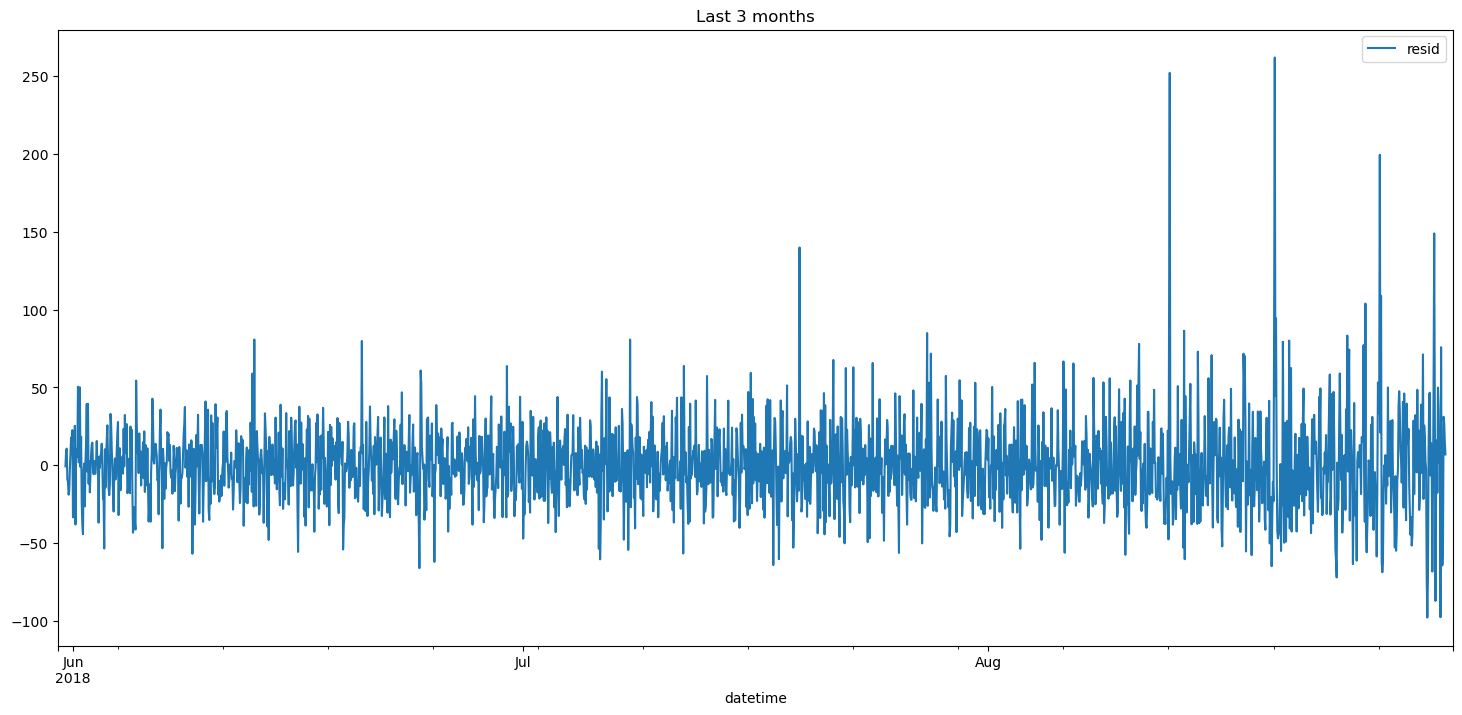

In [15]:
decomposed_data.resid.plot(figsize=figsize, legend=True, title='Last 3 months')

    На графике тренда за все время, можно заметить, что в общем, он возрастающий.
    Тоже самое можно сказать про тренд последних 3 месяцев.
    Сезонность циклична, как за весь интервал, так и за последние три месяца и за последнюю неделю.
    На всех интервалах замечено большое кол-во шумов.

<AxesSubplot:xlabel='datetime'>

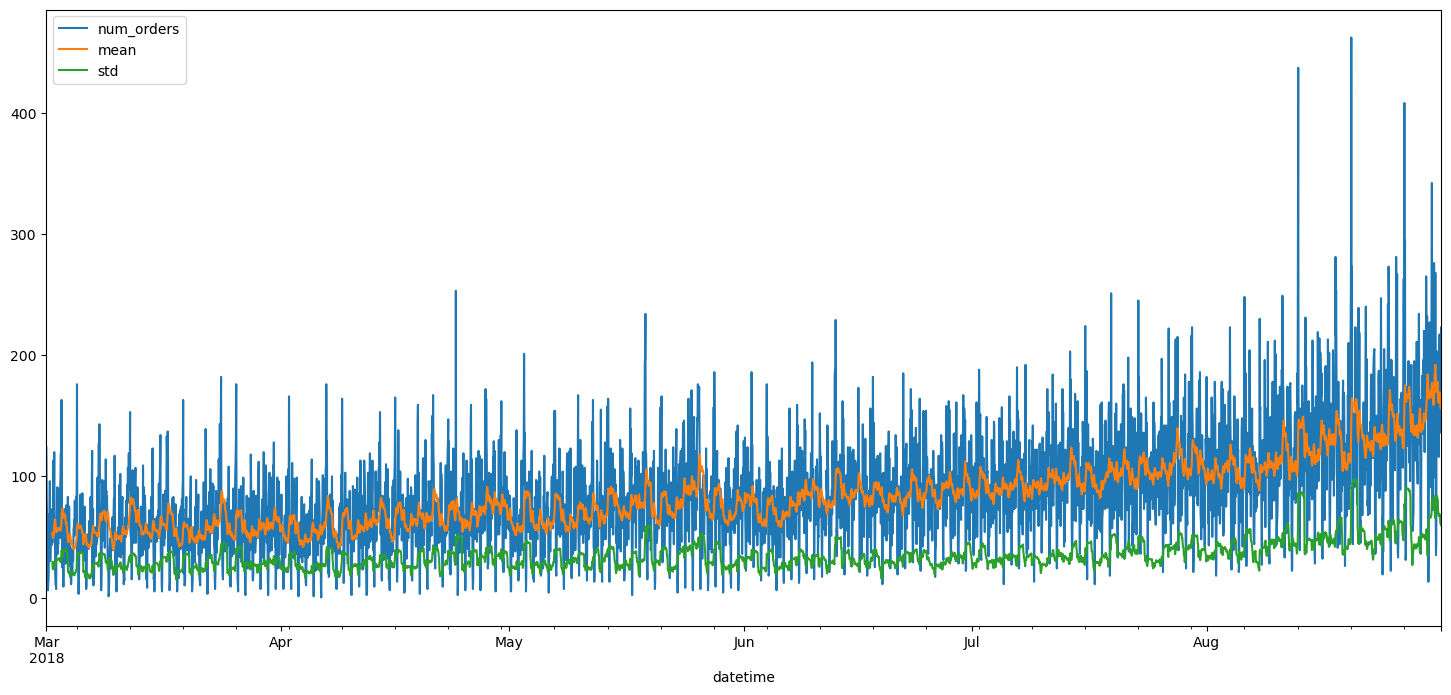

In [16]:
data['mean'] = data['num_orders'].rolling(20).mean()
data['std'] = data['num_orders'].rolling(20).std()
data.plot(figsize=figsize)

    Можно заметить, что данный временной интервал не стационарный.
  

In [17]:
# удалим ненужные колонки перед созданием признаков и обучением модели

data = data.drop(columns=['mean', 'std'])

## Обучение

In [18]:
# создадим копию даты

df = data.copy()

In [19]:
# пишем функцию, которая создает признаки

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
rmse_dict_1 = {}

Цикл для перебора значений rolling_mean_size. Так мы сможем подобрать наиболее подходящие параметры.

In [21]:
for i in range(1,40, 1):
  make_features(df, 1, i)

  # делим данные на две выборки: обучающую и тестовую
  # удаляем нулевые значения
  # обозначаем таргеты и фичи в выборках

  train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=STATE)
  
  train = train.dropna()
  target_train = train['num_orders']
  features_train = train.drop(columns=['num_orders'], axis=1)

  model = LinearRegression()
  split = TimeSeriesSplit(n_splits=3)
  
  lr_cv = (np.mean(cross_val_score(estimator=model, X=features_train, y=target_train,
                                   scoring='neg_root_mean_squared_error', cv=split)))*(-1)
  rmse_dict_1[i] = lr_cv

In [22]:
rmse_dict_1 = pd.DataFrame.from_dict(rmse_dict_1, orient='index')

<Figure size 1800x800 with 0 Axes>

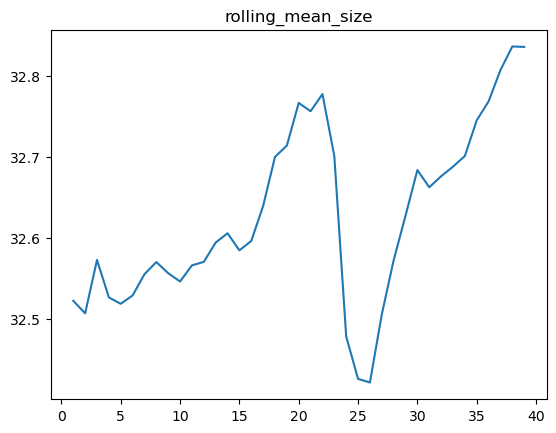

In [23]:
plt.figure(figsize=figsize)
rmse_dict_1.plot(legend=None)
plt.title('rolling_mean_size')
plt.show()

In [24]:
rmse_dict_2 = {}

In [25]:
for i in range(1,40,1):
    
    make_features(df, i, 1)
        
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    
    model = LinearRegression()
    split = TimeSeriesSplit(n_splits=3)
  
    lr_cv = (np.mean(cross_val_score(estimator=model, X=features_train, y=target_train,
                                   scoring='neg_root_mean_squared_error', cv=split)))*(-1)
    rmse_dict_2[i] = lr_cv

In [26]:
rmse_dict_2 = pd.DataFrame.from_dict(rmse_dict_2, orient='index')

<Figure size 1800x800 with 0 Axes>

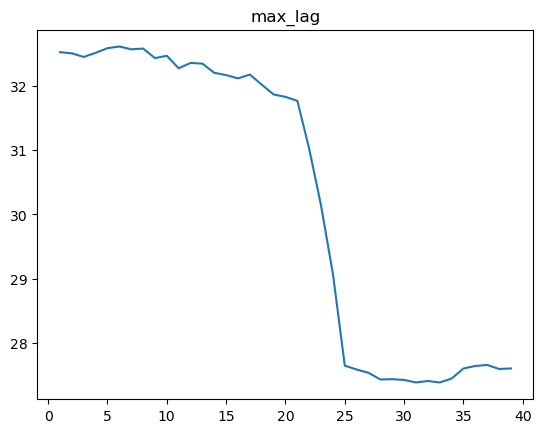

In [27]:
plt.figure(figsize=figsize)
rmse_dict_2.plot(legend=None)
plt.title('max_lag')
plt.show()

In [28]:
make_features(data, 24, 2)

In [29]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=STATE)

train = train.dropna()
test = test.dropna()

target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'], axis=1)

**LightGBM**

In [30]:
%%time
params = {'max_depth': [15, 20],
         'learning_rate': [0.01, 0.05, 0.1],
         'n_estimators': [100, 300],
         'reg_alpha': [0.1, 1],
         'reg_lambda': [0.5, 1]}

split = TimeSeriesSplit(n_splits=3)
lgb_model = LGBMRegressor(random_state=STATE)

lgb_grid = RandomizedSearchCV(lgb_model, param_distributions=params, scoring='neg_root_mean_squared_error', cv=split)
lgb_grid.fit(features_train, target_train)

Wall time: 15 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(random_state=17),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [15, 20],
                                        'n_estimators': [100, 300],
                                        'reg_alpha': [0.1, 1],
                                        'reg_lambda': [0.5, 1]},
                   scoring='neg_root_mean_squared_error')

In [31]:
lgb_estimator = lgb_grid.best_estimator_
lgb_estimator

LGBMRegressor(learning_rate=0.05, max_depth=15, random_state=17, reg_alpha=1,
              reg_lambda=1)

In [32]:
index = np.argmin(lgb_grid.cv_results_['rank_test_score'])
best_score_lgbm = (round(lgb_grid.cv_results_['mean_test_score'][index], 1))*(-1)
print(best_score_lgbm)

26.6


In [33]:
%%time
best_params = lgb_grid.best_params_
lgb_model = LGBMRegressor(random_state=STATE, n_estimators=best_params['n_estimators'], 
                           max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'],
                           reg_alpha=best_params['reg_alpha'], reg_lambda=best_params['reg_lambda'])
lgb_model.fit(features_train, target_train)

Wall time: 407 ms


LGBMRegressor(learning_rate=0.05, max_depth=15, random_state=17, reg_alpha=1,
              reg_lambda=1)

**Catboost**

In [34]:
%%time
cb_model = CatBoostRegressor(random_state=STATE, loss_function='RMSE', silent=True)

params = {'learning_rate': [0.03, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 5, 9]}

split = TimeSeriesSplit(n_splits=3)
cb_grid = RandomizedSearchCV(estimator=cb_model, cv=split, param_distributions=params,
                             scoring='neg_root_mean_squared_error', verbose=False)
cb_grid.fit(features_train, target_train)

Wall time: 18min 41s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001ADF3B44A90>,
                   param_distributions={'depth': [4, 6, 10],
                                        'l2_leaf_reg': [1, 5, 9],
                                        'learning_rate': [0.03, 0.1]},
                   scoring='neg_root_mean_squared_error', verbose=False)

In [35]:
cb_estimator = cb_grid.best_estimator_
cb_estimator

In [36]:
index=np.argmin(cb_grid.cv_results_['rank_test_score'])
best_score_cat=(round(cb_grid.cv_results_['mean_test_score'][index], 1))*(-1)
print(best_score_cat)

25.8


In [37]:
%%time
params_cat = cb_grid.best_params_
cb_model = CatBoostRegressor(random_state=STATE, loss_function='RMSE', silent=True,
                             learning_rate=params_cat['learning_rate'],
                             depth=params_cat['depth'],
                             l2_leaf_reg=params_cat['l2_leaf_reg'])
cb_model.fit(features_train, target_train)

Wall time: 10.6 s


После обучения двух моделей: LightGBM и Catboost, были получены результаты RMSE на тестовых выборках. Модель Catboost показала себя немного лучше, чем LightGBM, поэтому для тестирования будем брать ее.

## Тестирование

In [38]:
pred_cat = cb_estimator.predict(features_test)
rmse_test_cat = (mean_squared_error(target_test, pred_cat))**0.5
print('RMSE на тестовой выборке:', rmse_test_cat)

RMSE на тестовой выборке: 41.78507029508854


**Вывод**

- Были загружены и подготовлены данные
- Изучили сезонность и тренд
- Было выявлено большое кол-во шумов
- Пришли к выводу, что данный временной ряд стационарный
- Данные были разбиты на выборки
- Обучены две модели: LightGBM, Catboost
- На лучшей модели было проведено тестирование, итоговый RMSE оказался меньше 48